In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import segmentation_models_pytorch as smp
from sklearn.preprocessing import LabelEncoder
import random
# image operations
from PIL import Image
import os
import glob
import cv2
#from patchify import patchify,unpatchify
import matplotlib
import albumentations as A
# import gc
# import mlflow
# import mlflow.pytorch

In [2]:
cd training_pytorch

/home/shreeyash-legion/assignments/birla/fire-image-classification/training_pytorch


In [3]:
from utils.helper import seed_everything, get_default_device
seed_everything(0)
device = get_default_device()
device

device(type='cuda')

Creating dataset class

In [4]:
#! manually using dataClass

class load_dataset(Dataset):

    def __init__(self,parent_directory,positive_folder_name,negative_folder_name):
        '''
        parent_directory: Path to dataset
        positive_folder_name : folder name of positive class
        negative_folder_name : folder name of negative class
        '''
        self.parent_directory = parent_directory
        self.positive_folder_name = positive_folder_name
        self.negative_folder_name = negative_folder_name
    
    






In [5]:
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ]),
    
    "test": transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()])
    }

In [6]:
# automatically using ImageFolder class from torchvision
from torchvision import datasets

dataset_complete = datasets.ImageFolder('./fire_dataset', transform=image_transforms["train"])


In [7]:
dataset_complete.class_to_idx

{'non_fire_images': 0, 'with_fire_images': 1}

In [8]:
dataset_complete.samples[0]

('./fire_dataset/non_fire_images/non_fire.1.png', 0)

In [9]:
len(dataset_complete)

985

In [10]:
dataset_complete.class_to_idx

{'non_fire_images': 0, 'with_fire_images': 1}

In [11]:
def get_class_distribution(dataset_obj):
    idx2class = {v: k for k, v in dataset_obj.class_to_idx.items()}
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for element in dataset_obj:
        y_lbl = element[1]
        y_lbl = idx2class[y_lbl]
        count_dict[y_lbl] += 1
            
    return count_dict
dict_distribution=get_class_distribution(dataset_complete)
print('Distribution : ', dict_distribution)

Distribution :  {'non_fire_images': 230, 'with_fire_images': 755}


Text(0.5, 1.0, 'Natural Images Class Distribution')

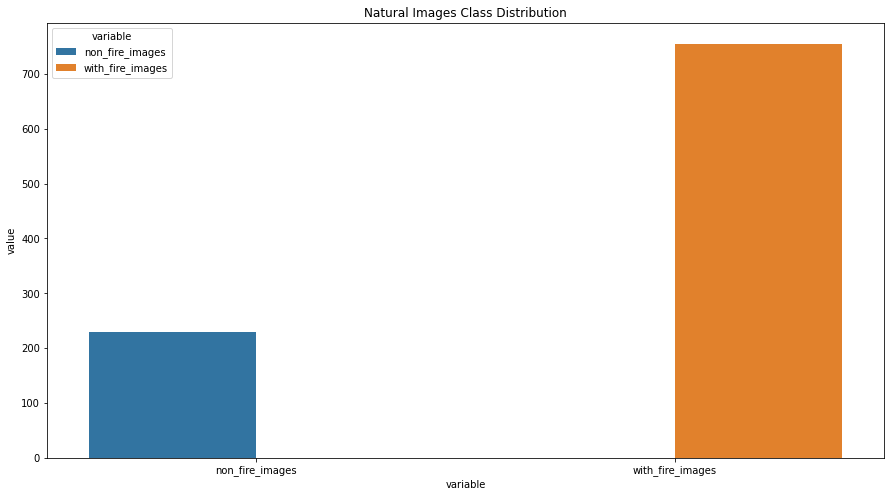

In [12]:
import seaborn as sns
import pandas as pd
plt.figure(figsize=(15,8))

sns.barplot(data = pd.DataFrame.from_dict([dict_distribution]).melt(), x = "variable", y="value", hue="variable").set_title('Natural Images Class Distribution')

In [13]:
from torch.utils.data import WeightedRandomSampler, random_split

In [14]:
train_dataset, val_dataset = random_split(dataset_complete, (900, 85))

In [15]:
len(train_dataset)

900

In [16]:
len(val_dataset)

85

In [17]:
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=1)
val_loader = DataLoader(dataset=val_dataset, shuffle=False, batch_size=1)

In [18]:
def get_class_distribution_loaders(dataloader_obj, dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    idx2class = {v: k for k, v in dataset_obj.class_to_idx.items()}
    for _,j in dataloader_obj:
        y_idx = j.item()
        y_lbl = idx2class[y_idx]
        count_dict[str(y_lbl)] += 1
            
    return count_dict

get_class_distribution_loaders(val_loader,dataset_complete)


{'non_fire_images': 19, 'with_fire_images': 66}

Text(0.5, 1.0, 'Val Set')

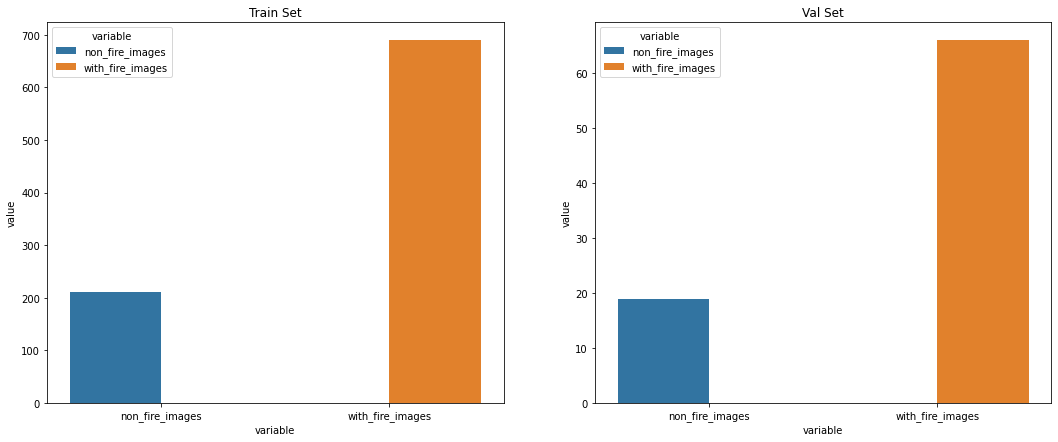

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,7))
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution_loaders(train_loader, dataset_complete)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Train Set')
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution_loaders(val_loader, dataset_complete)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Val Set')

In [20]:
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=8)
val_loader = DataLoader(dataset=val_dataset, shuffle=False, batch_size=8)

In [21]:
next(iter(train_loader))[0].shape

torch.Size([8, 3, 256, 256])

In [22]:
labels = dataset_complete.classes

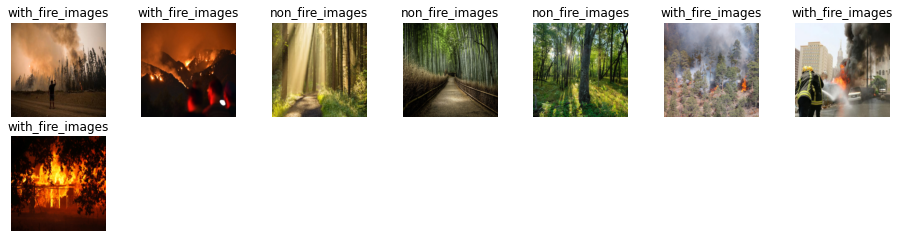

In [23]:
from utils.plot_utils import show_batch
show_batch(train_loader, labels)

In [24]:
#from models.resnet import resnet18
#model = resnet18("LN").to(device)
from utils.helper import model_summary

class BasicBlock(nn.Module):
    """
    Basic block of the ResNet.
    """

    expansion = 1

    def __init__(self, in_planes, planes, norm_type, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.GroupNorm(1, planes) if norm_type == "LN" else nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.GroupNorm(1, planes) if norm_type == "LN" else nn.BatchNorm2d(planes)

        # self.shortcut = nn.Sequential()
        # if stride != 1 or in_planes != self.expansion * planes:
        #     self.shortcut = nn.Sequential(
        #         nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
        #         nn.GroupNorm(1, self.expansion * planes)
        #         if norm_type == "LN"
        #         else nn.BatchNorm2d(self.expansion * planes),
        #     )

    def forward(self, x):
        """
        Forward method.
        """
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        #out += self.shortcut(x)
        out = F.relu(out)
        return out

class CustomResNetClass(nn.Module):
    """
    ResNet Architecture.
    """

    def __init__(self, block, norm_type, num_classes=10):
        super().__init__()
    #    self.in_planes = 64

    #     self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    #     self.bn1 = nn.GroupNorm(1, 64) if norm_type == "LN" else nn.BatchNorm2d(64)
    #     self.layer1 = self._make_layer(block, 64, num_blocks[0], norm_type, stride=1)
    #     self.layer2 = self._make_layer(block, 128, num_blocks[1], norm_type, stride=2)
    #     self.layer3 = self._make_layer(block, 256, num_blocks[2], norm_type, stride=2)
    #     self.layer4 = self._make_layer(block, 512, num_blocks[3], norm_type, stride=1)
    #     self.linear = nn.Linear(512 * block.expansion, num_classes)

    # def _make_layer(self, block, planes, num_blocks, norm_type, stride):
    #     strides = [stride] + [1] * (num_blocks - 1)
    #     layers = []
    #     for stride_ in strides:
    #         layers.append(block(self.in_planes, planes, norm_type, stride_))
    #         self.in_planes = planes * block.expansion
    #     return nn.Sequential(*layers)

        self.prep = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1,stride=1), # RF: 3x3
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )

        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1), # RF: 3x3
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.resblock_1 = block(128,128,norm_type="BN")
        
        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
    
        self.conv_layer_3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.resblock_2 = block(512,512,norm_type="BN")
        self.pooling = nn.MaxPool2d(4,4)
        self.fc1 = nn.Linear(512*8*8,2)


    def forward(self, x):
        """
        Forward method.
        """
        out = self.prep(x)
        out = self.conv_layer_1(out)
        
        res_out_1=self.resblock_1(out)
        
        out = out + res_out_1

        out = self.conv_layer_2(out)

        out = self.conv_layer_3(out)

        res_out_2=self.resblock_2(out)
        
        out = out + res_out_2 
        
        out = self.pooling(out)
        
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        
        #out = F.softmax(out,dim=1)
        return out

def CustomResNet(norm_type="BN"):
    return CustomResNetClass(BasicBlock,norm_type)

model = CustomResNet("BN").to(device)

model_summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
       BatchNorm2d-3         [-1, 64, 256, 256]             128
            Conv2d-4        [-1, 128, 256, 256]          73,856
         MaxPool2d-5        [-1, 128, 128, 128]               0
       BatchNorm2d-6        [-1, 128, 128, 128]             256
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,456
       BatchNorm2d-9        [-1, 128, 128, 128]             256
           Conv2d-10        [-1, 128, 128, 128]         147,456
      BatchNorm2d-11        [-1, 128, 128, 128]             256
       BasicBlock-12        [-1, 128, 128, 128]               0
           Conv2d-13        [-1, 256, 128, 128]         295,168
        MaxPool2d-14          [-1, 256,

In [25]:
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

epochs = 3
lr = 0.001
l1_factor = 0

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [26]:
# from torch_lr_finder import LRFinder
# lr_finder.reset()
# lr_finder = LRFinder(model, optimizer, criterion, device=device)
# lr_finder.range_test(train_loader,val_loader=test_loader,step_mode="linear",end_lr=0.5, num_iter=24*len(test_loader))
# max_lr=lr_finder.plot(suggest_lr=True,skip_start=0, skip_end=0)

In [27]:
from utils.test import test
from utils.train import train

from torch.optim.lr_scheduler import OneCycleLR
#l1_factor = 0

def trainer(model, epochs, device, train_loader, test_loader, optimizer, criterion, l1_factor, use_scheduler=True):
    """
    Train and evaluate for given epochs.
    """
    train_losses = []
    test_losses = []
    train_accuracy = []
    test_accuracy = []
    lrs = []
    #if use_scheduler:
    
    #scheduler = OneCycleLR(optimizer, max_lr = max_lr[1],epochs = 24, steps_per_epoch= len(train_loader),div_factor=10,pct_start=0.2)
    scheduler = OneCycleLR(optimizer, max_lr = 0.1,epochs = 24, steps_per_epoch= len(train_loader),div_factor=10,pct_start=0.2)
    for epoch in range(1, epochs + 1):
        print(f"Epoch {epoch}:")
        train(model, device, train_loader, optimizer, train_accuracy, train_losses, l1_factor, criterion, lrs,scheduler=None)
        test(model, device, test_loader, test_accuracy, test_losses, criterion)

        #if use_scheduler:
        scheduler.step(test_accuracy[-1])

    return train_accuracy, train_losses, test_accuracy, test_losses

In [28]:
train_accuracy, train_losses, test_accuracy, test_losses = trainer(model, epochs, device, train_loader, val_loader, optimizer, criterion, l1_factor)

  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 1:


Train Loss=3.088749885559082 Batch_id=112 LR= 0.01000 Train Accuracy= 79.89: 100%|██████████| 113/113 [00:54<00:00,  2.08it/s]
  0%|          | 0/113 [00:00<?, ?it/s]


: Average Test loss: 0.0520, Test Accuracy: 66/85 (77.65%)

Epoch 2:


Train Loss=0.29751652479171753 Batch_id=112 LR= 0.01449 Train Accuracy= 87.89: 100%|██████████| 113/113 [00:56<00:00,  2.02it/s]
  0%|          | 0/113 [00:00<?, ?it/s]


: Average Test loss: 0.0443, Test Accuracy: 70/85 (82.35%)

Epoch 3:


Train Loss=0.29673558473587036 Batch_id=112 LR= 0.01504 Train Accuracy= 80.78: 100%|██████████| 113/113 [01:00<00:00,  1.88it/s]



: Average Test loss: 0.0773, Test Accuracy: 72/85 (84.71%)



Total wrong predictions are 13


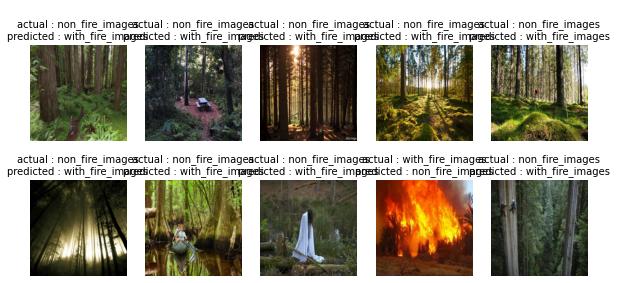

In [29]:
from utils.plot_utils import misclassified_images

images_misclassified = misclassified_images(model, val_loader, device,labels)

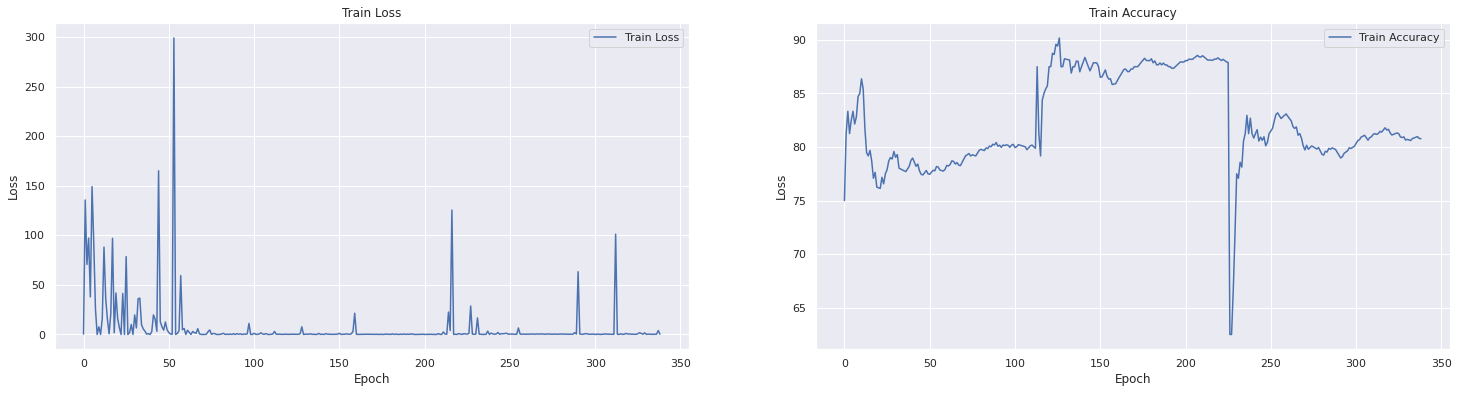

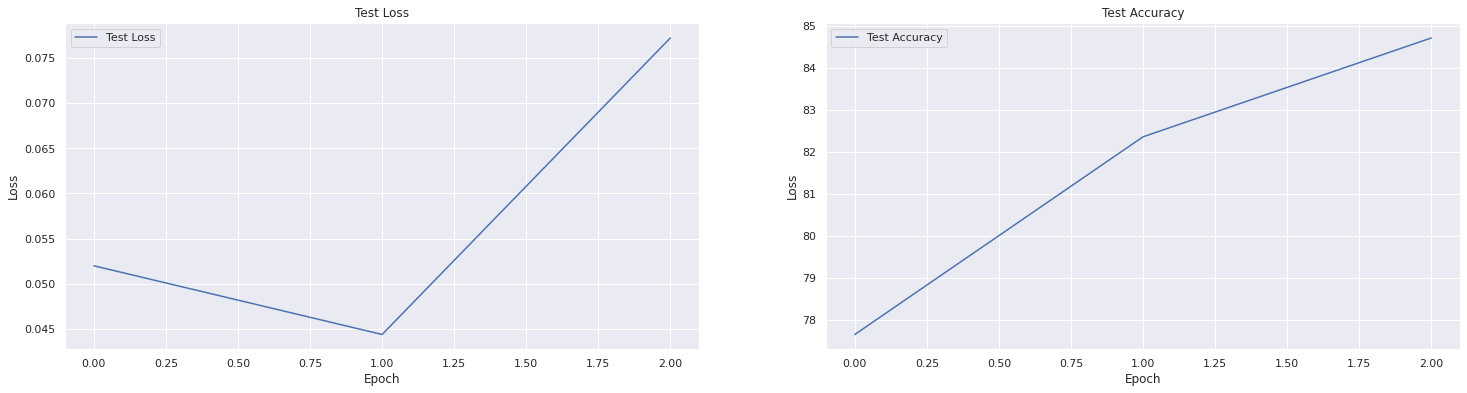

In [30]:
from utils.plot_utils import plot_metrics

plot_metrics((train_accuracy, train_losses, test_accuracy, test_losses))

In [34]:
from utils.helper import class_level_accuracy

class_level_accuracy(model, val_loader, device, labels)

Accuracy of non_fire_images : 42 %
Accuracy of with_fire_images : 96 %


Generating Grad-CAM for conv_layer_1
Generating Grad-CAM for conv_layer_2
Generating Grad-CAM for conv_layer_3


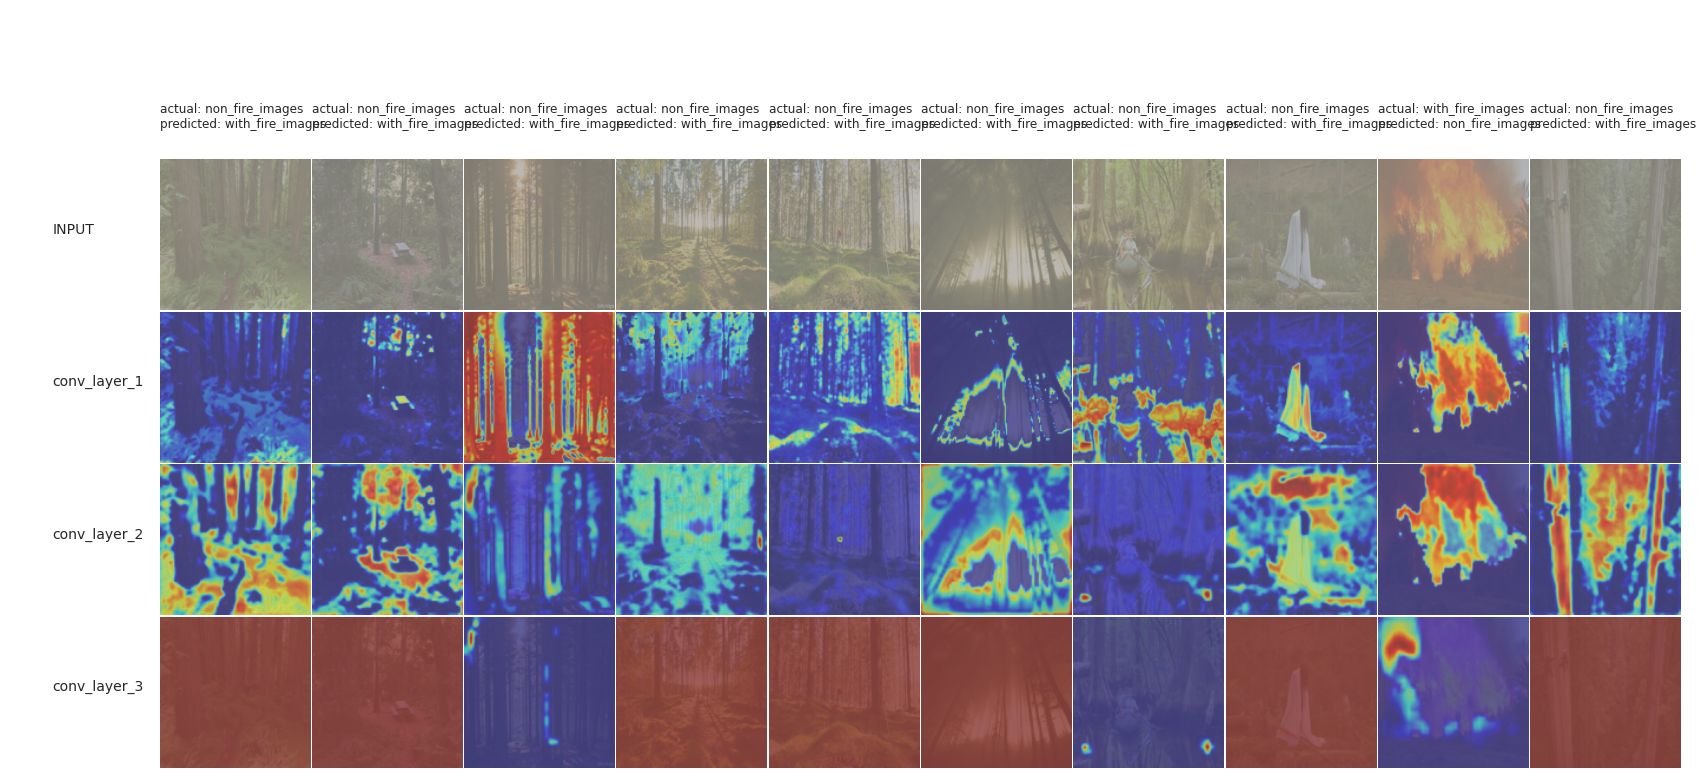

In [35]:
from utils.grad_cam import generate_gradcam, plot_gradcam

target_layers = ["conv_layer_1", "conv_layer_2", "conv_layer_3"]
gradcam_output, probs, predicted_classes = generate_gradcam(images_misclassified[:10], model, target_layers, device)
plot_gradcam(gradcam_output, target_layers, labels, (3, 256, 256), predicted_classes, images_misclassified[:10])